# Kalman Filter Python Exercises: From Single-Variable Filtering to Sensor Fusion

In [3]:
# Import core modules
import os
import sys
workspace_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if workspace_root not in sys.path:
    sys.path.insert(0, workspace_root)
print("Using workspace root:", workspace_root)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from scipy import stats
import numpy as np
from core.bayesfilter import SimpleKalmanFilter, MultiSensorKalmanFilter

Using workspace root: /Users/songfei/Study/gitclone/searching_exercise


Example 1: Removing zero-mean Gaussian noise
Problem setup:

- Assume the true signal is constant: $x = 10 + q$, $q \sim \mathcal{N}(0, 0.01)$, small Q because we assume the true value is almost fixed
- Observed noisy signal: $z = 10 + r$, $r \sim \mathcal{N}(0, 4)$

Goal: estimate the true value from noisy observations

Example 1: Filter Gaussian noise
Measurement MSE: 3.6206
Filtered MSE: 0.4003
Improvement: 88.9%
Final Kalman gain: 0.0198
Final uncertainty: 0.0792


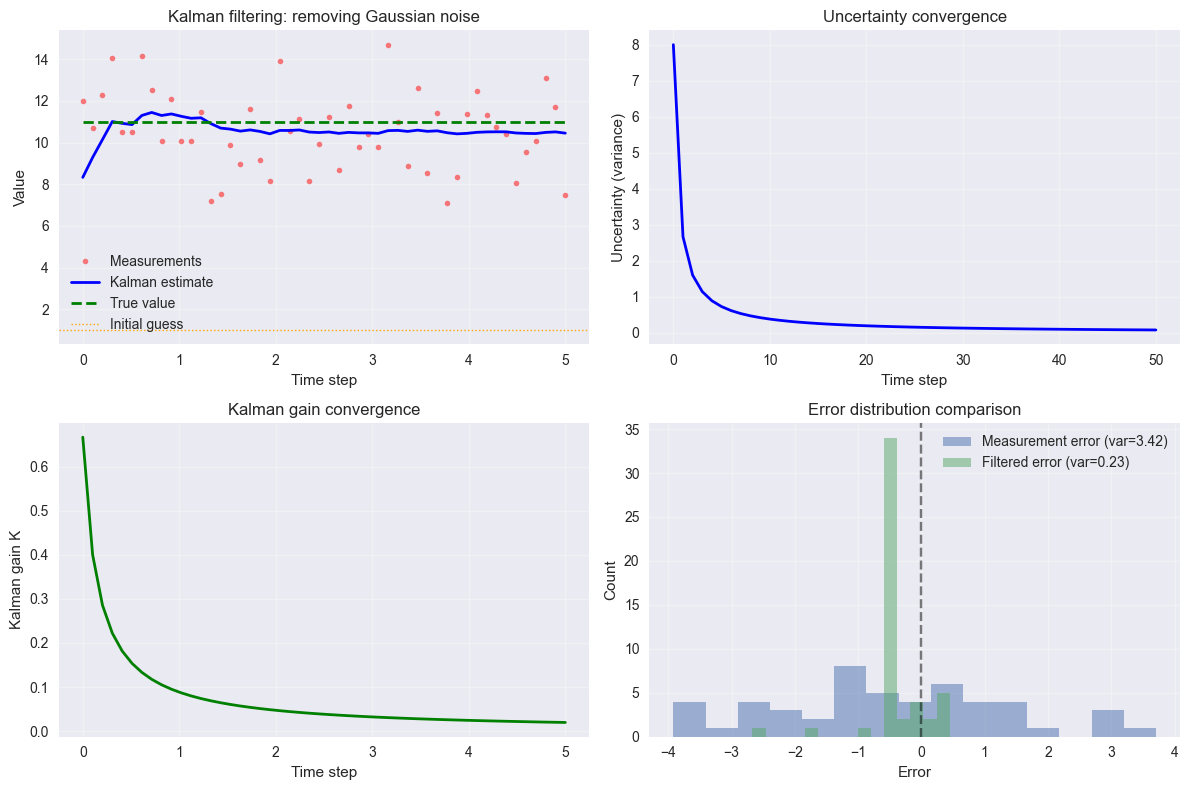

In [4]:
# """Example 1: filter Gaussian noise to estimate a constant signal"""
np.random.seed(42)

# STEP 1: Generate state and noisy measurements
T = 50
dT = 0.1
time_steps = np.linspace(0, T*dT, T)

# Generate true state
state = 10.0 + np.ones(np.shape(time_steps))

# Generate noisy measurements
measurement_noise_variance = 4.0  # R = 4
observations = state + np.random.normal(0, np.sqrt(measurement_noise_variance), size=state.shape)

# STEP 2: Build Kalman filter
# Initial guess (intentionally rough)
prior_state = 1.0
prior_uncertainty = 8.0  # Large initial uncertainty
prior_process_variance = 0.02  #  Assumed process variance, can be tuned

kf = SimpleKalmanFilter(
    prior_state=prior_state,
    prior_uncertainty=prior_uncertainty,
    process_variance=prior_process_variance,
    measurement_variance=measurement_noise_variance
)

# Filtering
filtered_states, kalman_gains = kf.filter(observations)

# STEP 3: Evaluate results
# Compute performance metrics
measurements_mse = np.mean((observations - state)**2)
filtered_mse = np.mean((filtered_states - state)**2)

print("=" * 50)
print("Example 1: Filter Gaussian noise")
print("=" * 50)
print(f"Measurement MSE: {measurements_mse:.4f}")
print(f"Filtered MSE: {filtered_mse:.4f}")
print(f"Improvement: {(measurements_mse - filtered_mse)/measurements_mse*100:.1f}%")
print(f"Final Kalman gain: {kalman_gains[-1]:.4f}")
print(f"Final uncertainty: {kf.uncertainties[-1]:.4f}")

# STEP 4: Visualization
plt.figure(figsize=(12, 8))

# Subplot 1: signal and estimate
plt.subplot(2, 2, 1)
plt.plot(time_steps, observations, 'ro', alpha=0.5, label='Measurements', markersize=4)
plt.plot(time_steps, filtered_states, 'b-', linewidth=2, label='Kalman estimate')
plt.plot(time_steps, state, 'g--', linewidth=2, label='True value')
plt.axhline(y=prior_state, color='orange', linestyle=':', linewidth=1, label='Initial guess')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Kalman filtering: removing Gaussian noise')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: uncertainty trend
plt.subplot(2, 2, 2)
plt.plot(range(len(kf.uncertainties)), kf.uncertainties, 'b-', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Uncertainty (variance)')
plt.title('Uncertainty convergence')
plt.grid(True, alpha=0.3)

# Subplot 3: Kalman gain trend
plt.subplot(2, 2, 3)
plt.plot(time_steps, kalman_gains, 'g-', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Kalman gain K')
plt.title('Kalman gain convergence')
plt.grid(True, alpha=0.3)

# Subplot 4: error distribution
plt.subplot(2, 2, 4)
measurement_errors = observations - state
filtered_errors = filtered_states - state
plt.hist(measurement_errors, bins=15, alpha=0.5, label=f'Measurement error (var={np.var(measurement_errors):.2f})')
plt.hist(filtered_errors, bins=15, alpha=0.5, label=f'Filtered error (var={np.var(filtered_errors):.2f})')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Error distribution comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

Example 2: Sensor fusion (combining two noisy sensors)
Problem setup:
- True signal: $x(t) = t^2$
- Two sensors:

    - Sensor A: $y_a(t) = x(t) + v_a$, $v_a \sim \mathcal{N}(0, \sigma_a^2), \sigma_a=5.0$

    - Sensor B: $y_b(t) = x(t) + v_b$, $v_b \sim \mathcal{N}(0, \sigma_b^2), \sigma_b=1.0$

Key insight: treat the two sensors as a "virtual sensor" whose observation noise is the harmonic mean of the two.

Example 2: Sensor fusion (true signal: x(t) = t^2)
Sensor A noise std: 5.0, variance: 25.0
Sensor B noise std: 1.0, variance: 1.0

MSE comparison:
  Sensor A only: 20.6827
  Sensor B only: 0.9009
  Weighted average: 0.8194 (weights: A=0.038, B=0.962)
  Kalman fusion: 0.3349

Improvement vs sensor A: 98.4%
Improvement vs sensor B: 62.8%
Improvement vs weighted average: 59.1%


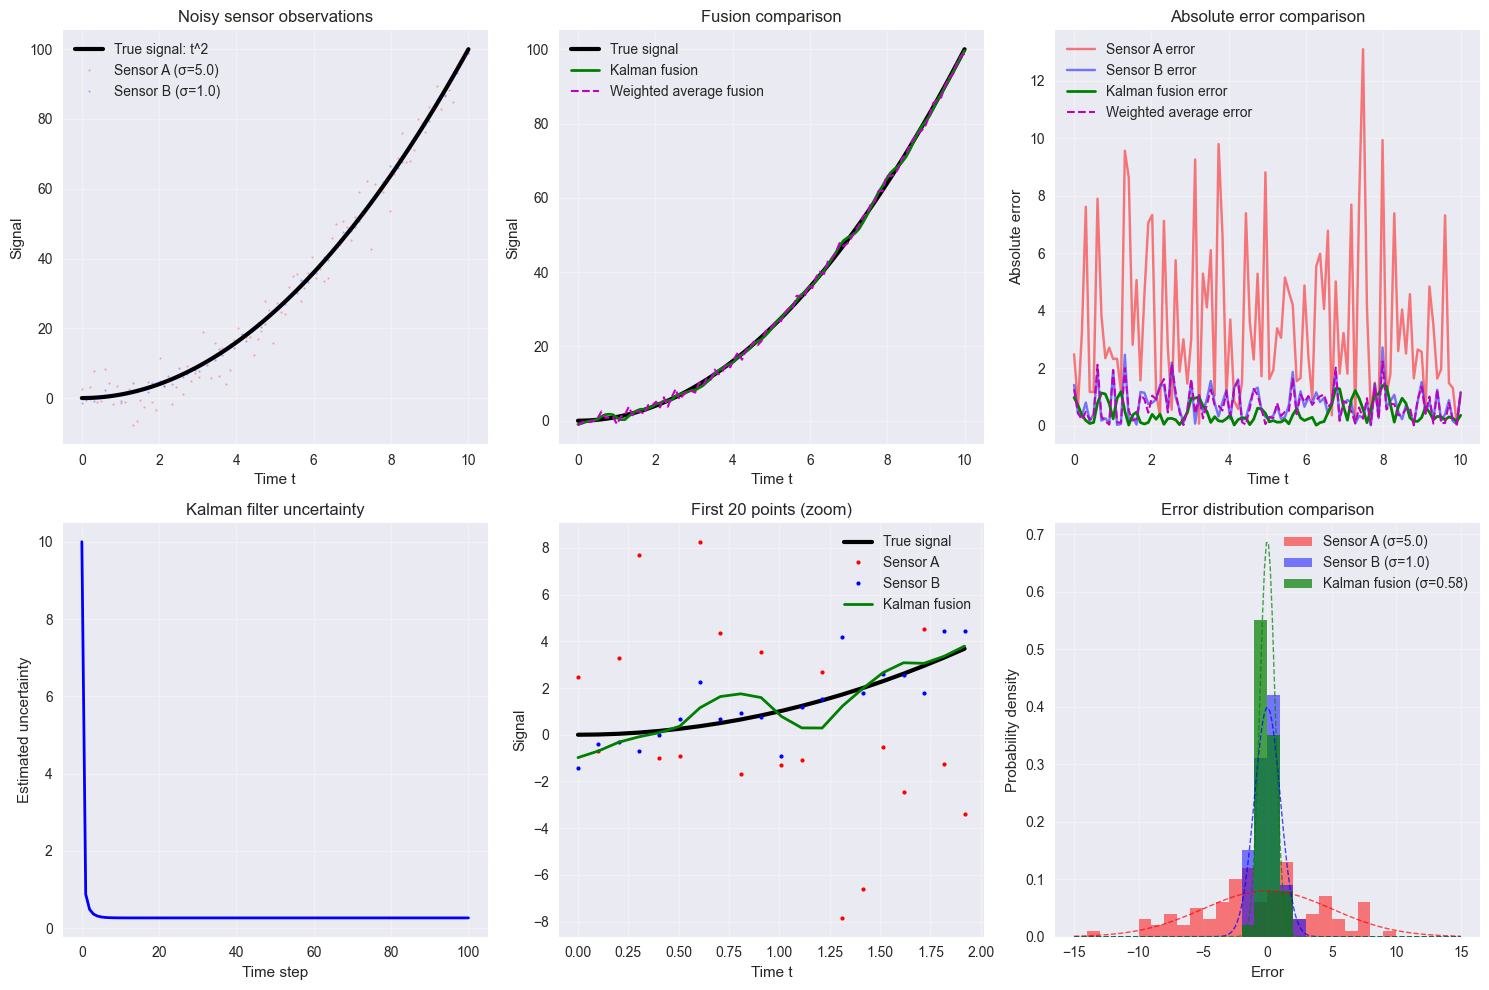


Theoretical analysis:
Sensor A variance: 25.00
Sensor B variance: 1.00
Theoretical optimal fusion variance: 0.9615
Theoretical optimal fusion std: 0.9806
Actual Kalman fusion variance: 0.3334
Actual weighted average variance: 0.8194

Dynamic weight analysis (first 5 points):
time | true | sensor A | sensor B | Kalman estimate | Kalman uncertainty
--------------------------------------------------------------------------------
 0.0 |    0.00 |     2.48 |    -1.42 |       -0.98 |          0.8772
 0.1 |    0.01 |    -0.68 |    -0.41 |       -0.70 |          0.4847
 0.2 |    0.04 |     3.28 |    -0.30 |       -0.32 |          0.3636
 0.3 |    0.09 |     7.71 |    -0.71 |       -0.09 |          0.3128
 0.4 |    0.16 |    -1.01 |     0.00 |        0.09 |          0.2888


In [5]:
# """Example 2: sensor fusion"""
np.random.seed(42)

# STEP 1: Generate true signal and noisy measurements from two sensors
n_points = 100
time_steps = np.linspace(0, 10, n_points)

# Generate true signal: x(t) = t^2
true_signal = time_steps**2 

# Generate noisy sensor data, linearly independent noise
sigma_A = 5.0  # Sensor A has large noise
sigma_B = 1.0  # Sensor B has small noise
var_A = sigma_A**2
var_B = sigma_B**2
noise_A = np.random.randn(n_points) * sigma_A
noise_B = np.random.randn(n_points) * sigma_B
measurements_A = true_signal + noise_A
measurements_B = true_signal + noise_B

# STEP 2: Build filter
# Initial guess: true start is 0, but we deliberately offset it
prior_state = 2.0  # True initial state is 0
prior_uncertainty = 10.0
prior_process_variance = 0.1  # assumed process variance, can be tuned

kf = MultiSensorKalmanFilter(
    prior_state=prior_state,
    prior_uncertainty=prior_uncertainty,
    process_variance=prior_process_variance
)

# Batch filtering
filtered_states = kf.batch_filter(
    range(n_points),
    measurements_A,
    measurements_B,
    var_A,
    var_B
)

# Performance metrics
mse_A = np.mean((measurements_A - true_signal)**2)
mse_B = np.mean((measurements_B - true_signal)**2)
mse_fusion = np.mean((filtered_states - true_signal)**2)

# STEP 3: Theoretical optimal fusion weights
# Static case optimal weights: w_A = σ_B²/(σ_A²+σ_B²), w_B = σ_A²/(σ_A²+σ_B²)
w_A_optimal = var_B / (var_A + var_B)
w_B_optimal = var_A / (var_A + var_B)

# Simple weighted average for comparison
simple_fusion = w_A_optimal * measurements_A + w_B_optimal * measurements_B
mse_simple_fusion = np.mean((simple_fusion - true_signal)**2)

print("=" * 70)
print("Example 2: Sensor fusion (true signal: x(t) = t^2)")
print("=" * 70)
print(f"Sensor A noise std: {sigma_A:.1f}, variance: {var_A:.1f}")
print(f"Sensor B noise std: {sigma_B:.1f}, variance: {var_B:.1f}")
print("\nMSE comparison:")
print(f"  Sensor A only: {mse_A:.4f}")
print(f"  Sensor B only: {mse_B:.4f}")
print(f"  Weighted average: {mse_simple_fusion:.4f} (weights: A={w_A_optimal:.3f}, B={w_B_optimal:.3f})")
print(f"  Kalman fusion: {mse_fusion:.4f}")
print(f"\nImprovement vs sensor A: {(mse_A - mse_fusion)/mse_A*100:.1f}%")
print(f"Improvement vs sensor B: {(mse_B - mse_fusion)/mse_B*100:.1f}%")
print(f"Improvement vs weighted average: {(mse_simple_fusion - mse_fusion)/mse_simple_fusion*100:.1f}%")

# STEP 4: Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: signals
plt.subplot(2, 3, 1)
plt.plot(time_steps, true_signal, 'k-', linewidth=3, label='True signal: t^2')
plt.plot(time_steps, measurements_A, 'r.', alpha=0.3, markersize=3, label=f'Sensor A (σ={sigma_A})')
plt.plot(time_steps, measurements_B, 'b.', alpha=0.3, markersize=3, label=f'Sensor B (σ={sigma_B})')
plt.xlabel('Time t')
plt.ylabel('Signal')
plt.title('Noisy sensor observations')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: fusion results
plt.subplot(2, 3, 2)
plt.plot(time_steps, true_signal, 'k-', linewidth=3, label='True signal')
plt.plot(time_steps, filtered_states, 'g-', linewidth=2, label='Kalman fusion')
plt.plot(time_steps, simple_fusion, 'm--', linewidth=1.5, label='Weighted average fusion')
plt.xlabel('Time t')
plt.ylabel('Signal')
plt.title('Fusion comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: error over time
plt.subplot(2, 3, 3)
error_A = np.abs(measurements_A - true_signal)
error_B = np.abs(measurements_B - true_signal)
error_fusion = np.abs(filtered_states - true_signal)
error_simple = np.abs(simple_fusion - true_signal)

plt.plot(time_steps, error_A, 'r-', alpha=0.5, label='Sensor A error')
plt.plot(time_steps, error_B, 'b-', alpha=0.5, label='Sensor B error')
plt.plot(time_steps, error_fusion, 'g-', linewidth=2, label='Kalman fusion error')
plt.plot(time_steps, error_simple, 'm--', linewidth=1.5, label='Weighted average error')
plt.xlabel('Time t')
plt.ylabel('Absolute error')
plt.title('Absolute error comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: uncertainty convergence
plt.subplot(2, 3, 4)
plt.plot(range(len(kf.uncertainties)), kf.uncertainties, 'b-', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Estimated uncertainty')
plt.title('Kalman filter uncertainty')
plt.grid(True, alpha=0.3)

# Subplot 5: zoom into first 20 points
plt.subplot(2, 3, 5)
n_show = min(20, n_points)
plt.plot(time_steps[:n_show], true_signal[:n_show], 'k-', linewidth=3, label='True signal')
plt.plot(time_steps[:n_show], measurements_A[:n_show], 'r.', markersize=6, label='Sensor A')
plt.plot(time_steps[:n_show], measurements_B[:n_show], 'b.', markersize=6, label='Sensor B')
plt.plot(time_steps[:n_show], filtered_states[:n_show], 'g-', linewidth=2, label='Kalman fusion')
plt.xlabel('Time t')
plt.ylabel('Signal')
plt.title('First 20 points (zoom)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: error distribution
plt.subplot(2, 3, 6)
bins = np.linspace(-15, 15, 31)
plt.hist(measurements_A - true_signal, bins=bins, alpha=0.5, 
            label=f'Sensor A (σ={sigma_A:.1f})', density=True, color='red')
plt.hist(measurements_B - true_signal, bins=bins, alpha=0.5, 
            label=f'Sensor B (σ={sigma_B:.1f})', density=True, color='blue')
plt.hist(filtered_states - true_signal, bins=bins, alpha=0.7, 
            label=f'Kalman fusion (σ={np.std(filtered_states - true_signal):.2f})', density=True, color='green')

# Plot theoretical Gaussian distributions
x = np.linspace(-15, 15, 200)
plt.plot(x, stats.norm.pdf(x, 0, sigma_A), 'r--', alpha=0.7, linewidth=1)
plt.plot(x, stats.norm.pdf(x, 0, sigma_B), 'b--', alpha=0.7, linewidth=1)
plt.plot(x, stats.norm.pdf(x, 0, np.std(filtered_states - true_signal)), 'g--', alpha=0.7, linewidth=1)
plt.xlabel('Error')
plt.ylabel('Probability density')
plt.title('Error distribution comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 5: Print theoretical analysis
print("\n" + "="*70)
print("Theoretical analysis:")
print("="*70)

# Static case optimal variance for two independent observations: σ²_fusion = 1/(1/σ_A² + 1/σ_B²)
theoretical_optimal_variance = 1/(1/var_A + 1/var_B)
theoretical_optimal_std = np.sqrt(theoretical_optimal_variance)

print(f"Sensor A variance: {var_A:.2f}")
print(f"Sensor B variance: {var_B:.2f}")
print(f"Theoretical optimal fusion variance: {theoretical_optimal_variance:.4f}")
print(f"Theoretical optimal fusion std: {theoretical_optimal_std:.4f}")
print(f"Actual Kalman fusion variance: {np.var(filtered_states - true_signal):.4f}")
print(f"Actual weighted average variance: {np.var(simple_fusion - true_signal):.4f}")

# Dynamic weight analysis
print("\nDynamic weight analysis (first 5 points):")
print("time | true | sensor A | sensor B | Kalman estimate | Kalman uncertainty")
print("-" * 80)
for i in range(min(5, n_points)):
    print(f"{time_steps[i]:4.1f} | {true_signal[i]:7.2f} | {measurements_A[i]:8.2f} | {measurements_B[i]:8.2f} | {filtered_states[i]:11.2f} | {kf.uncertainties[i+1]:15.4f}")


---

# Particle Filter Python Exercise

In [ ]:
# Import core modules
import os
import sys
workspace_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if workspace_root not in sys.path:
    sys.path.insert(0, workspace_root)
print("Using workspace root:", workspace_root)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from scipy import stats
import numpy as np
from core.bayesfilter import ParticleFilter

Using workspace root: /Users/songfei/Study/gitclone/searching_exercise


Example 1: 1D position tracking with noisy odometry + GPS
- True motion: constant +1 step with process noise ($q \sim \mathcal{N}(0, 0.5^2)$)
- Observation: position-only GPS with noise ($r \sim \mathcal{N}(0, 1.0^2)$)
- Tasks: recover the hidden trajectory

1D Particle Filter configuration
Particles: 1000, Steps: 30
Process noise std: 0.500
Observation noise std: 1.000
First few steps (true | obs | estimate | ESS | particle σ):
00 |   1.700 |   2.624 |   1.908 |   564.9 |   0.738
01 |   2.520 |   2.821 |   2.868 |   888.9 |   0.673
02 |   4.031 |   4.950 |   4.303 |   748.6 |   0.629
03 |   5.590 |   6.864 |   5.922 |   591.5 |   0.646
04 |   6.681 |   5.645 |   6.413 |   686.2 |   0.620
----------------------------------------------------------------------
Observation-only RMSE: 0.9986
PF RMSE: 0.6440, MAE: 0.5308
Final ESS: 718.6 / 1000
Mean ESS: 714.4, Min ESS: 157.1
Final estimate: 25.941, True final: 26.815


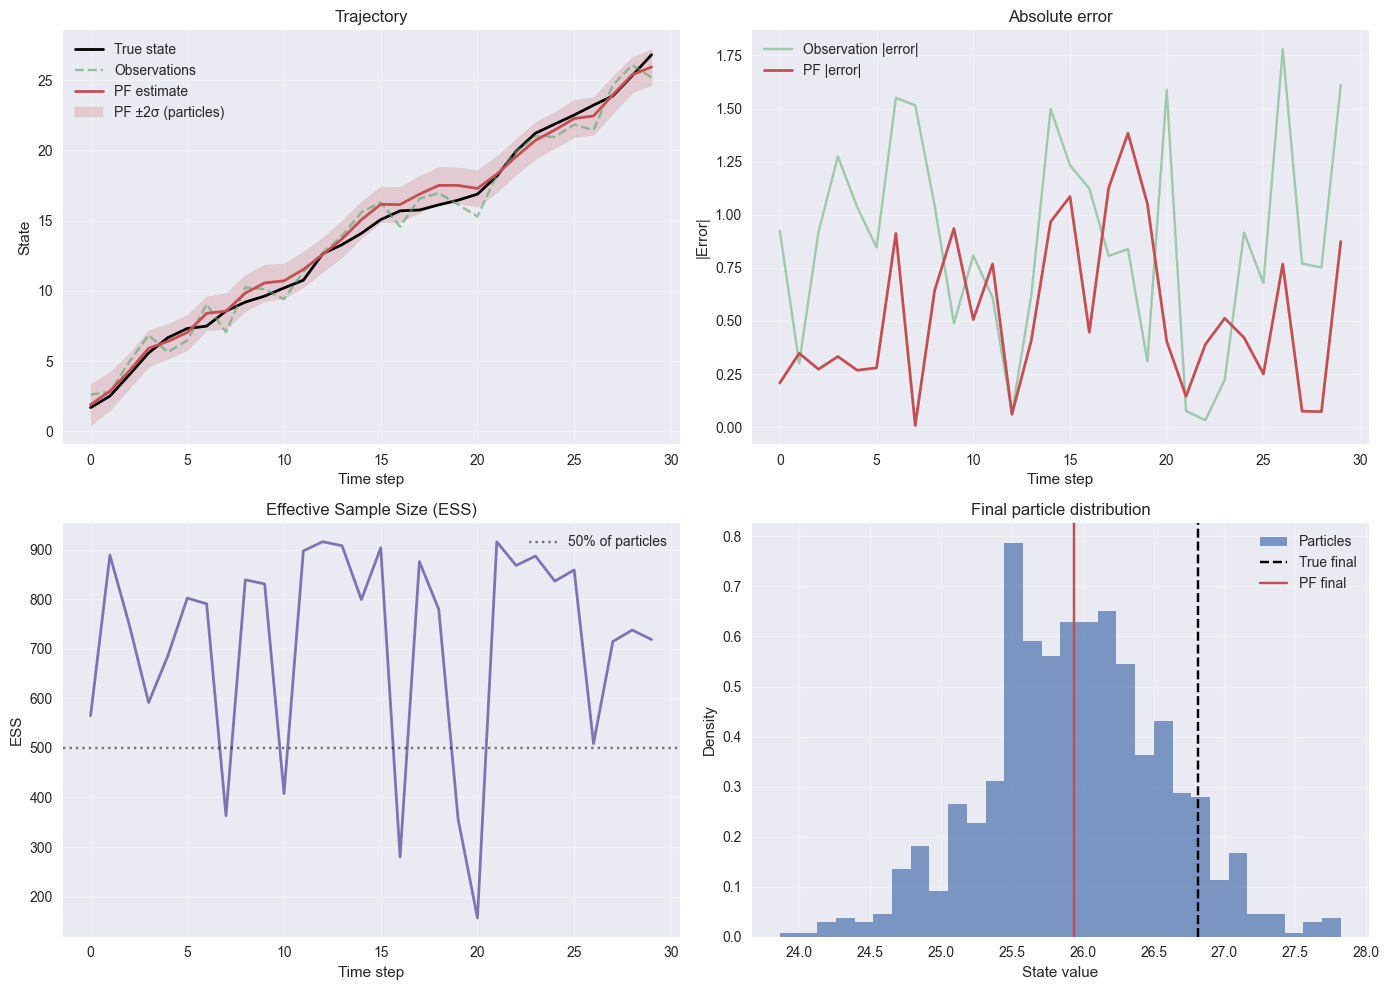

In [ ]:
# Example 1: 1D particle filter - position tracking (motion + GPS)
np.random.seed(42)

# STEP 1: define dimensions and noise models
state_dim = 1
num_particles = 1000
T = 30

# Motion model: x_t = x_{t-1} + 1 + process_noise
def motion_model_1d(x):
    return x + 1
# Observation model: z_t = x_t + observation_noise
def obs_model_1d(x):
    return x

process_noise = np.array([[0.5**2]])  # process covariance, Q
observation_noise = np.array([[1.0**2]])  # observation covariance, R

print("=" * 70)
print("1D Particle Filter configuration")
print(f"Particles: {num_particles}, Steps: {T}")
print(f"Process noise std: {np.sqrt(process_noise[0, 0]):.3f}")
print(f"Observation noise std: {np.sqrt(observation_noise[0, 0]):.3f}")
print("=" * 70)

# STEP 2: define particle filter
pf = ParticleFilter(
    num_particles,
    state_dim,
    motion_model_1d,
    obs_model_1d,
    process_noise,
    observation_noise,
)

# STEP 2-0: generate true trajectory and observations
x_true = 0.0
true_states = []
observations = []
estimates = []
ess_history = []
particle_std_history = []

for t in range(T):
    # STEP 2-1: simulate true state and observation
    x_true += 1 + np.random.normal(0, np.sqrt(process_noise[0, 0]))
    z = x_true + np.random.normal(0, np.sqrt(observation_noise[0, 0]))

    true_states.append(x_true)
    observations.append(z)

    # STEP 2-2: predict and update with current measurement
    pf.predict()
    pf.update(np.array([z]))

    # STEP 2-3: evaluate degeneracy and resample
    ess = pf.effective_sample_size()
    ess_history.append(ess)
    pf.resample()

    # STEP 2-4: estimate state and track spread
    est = pf.estimate()
    estimates.append(est[0])
    particle_std_history.append(np.std(pf.particles[:, 0]))

top_k = min(5, T)
true_states = np.array(true_states)
observations = np.array(observations)
estimates = np.array(estimates)
particle_std_history = np.array(particle_std_history)
ess_history = np.array(ess_history)
time_axis = np.arange(T)

# STEP 3: metrics
rmse = np.sqrt(np.mean((true_states - estimates) ** 2))
mae = np.mean(np.abs(true_states - estimates))
raw_rmse = np.sqrt(np.mean((true_states - observations) ** 2))

print("First few steps (true | obs | estimate | ESS | particle σ):")
for i in range(top_k):
    print(
        f"{i:02d} | {true_states[i]:7.3f} | {observations[i]:7.3f} | "
        f"{estimates[i]:7.3f} | {ess_history[i]:7.1f} | {particle_std_history[i]:7.3f}"
    )
print("-" * 70)
print(f"Observation-only RMSE: {raw_rmse:.4f}")
print(f"PF RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"Final ESS: {ess_history[-1]:.1f} / {num_particles}")
print(f"Mean ESS: {np.mean(ess_history):.1f}, Min ESS: {np.min(ess_history):.1f}")
print(f"Final estimate: {estimates[-1]:.3f}, True final: {true_states[-1]:.3f}")

# STEP 4: visualization with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# subplot 1: Trajectory with particle spread
axes[0, 0].plot(time_axis, true_states, label="True state", linewidth=2, color="k")
axes[0, 0].plot(time_axis, observations, label="Observations", linestyle="--", color="C1", alpha=0.6)
axes[0, 0].plot(time_axis, estimates, label="PF estimate", color="C2", linewidth=2)
axes[0, 0].fill_between(
    time_axis,
    estimates - 2 * particle_std_history,
    estimates + 2 * particle_std_history,
    color="C2",
    alpha=0.2,
    label="PF ±2σ (particles)",
)

axes[0, 0].set_title("Trajectory")
axes[0, 0].set_xlabel("Time step")
axes[0, 0].set_ylabel("State")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# subplot 2: Absolute error over time
axes[0, 1].plot(time_axis, np.abs(true_states - observations), label="Observation |error|", alpha=0.5, color="C1")
axes[0, 1].plot(time_axis, np.abs(true_states - estimates), label="PF |error|", linewidth=2, color="C2")
axes[0, 1].set_title("Absolute error")
axes[0, 1].set_xlabel("Time step")
axes[0, 1].set_ylabel("|Error|")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# subplot 3: Effective sample size
axes[1, 0].plot(time_axis, ess_history, color="C3", linewidth=2)
axes[1, 0].axhline(num_particles * 0.5, color="k", linestyle=":", alpha=0.5, label="50% of particles")
axes[1, 0].set_title("Effective Sample Size (ESS)")
axes[1, 0].set_xlabel("Time step")
axes[1, 0].set_ylabel("ESS")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# subplot 4: Final particle distribution
axes[1, 1].hist(pf.particles[:, 0], bins=30, density=True, alpha=0.7, label="Particles")
axes[1, 1].axvline(true_states[-1], color="k", linestyle="--", label="True final")
axes[1, 1].axvline(estimates[-1], color="C2", linestyle="-", label="PF final")
axes[1, 1].set_title("Final particle distribution")
axes[1, 1].set_xlabel("State value")
axes[1, 1].set_ylabel("Density")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Example 2: 2D constant-velocity tracking
- Hidden state: $x=[p, v]$ (position, velocity) with nearly constant velocity
- Motion model: $p_t = p_{t-1} + v_{t-1} + q_p$, $v_t = v_{t-1} + q_v$
- Observation: position-only GPS $z_t = p_t + r$
- Goals: track both position and velocity

2D Particle Filter configuration
Particles: 1000, Steps: 30
Process noise std (pos, vel): [0.5 0.1]
Observation noise std (pos): 1.000
First few steps (pos_true | obs | pos_est | vel_true | vel_est | ESS | σ_pos | σ_vel):
00 |   0.113 |   1.209 |   0.867 |   0.880 |   0.379 |   610.4 |  0.835 |  0.793
01 |   0.812 |  -0.370 |   0.093 |   0.739 |  -0.105 |   524.2 |  0.809 |  0.597
02 |   1.865 |   2.127 |   1.325 |   0.656 |   0.407 |   391.1 |  0.788 |  0.528
03 |   2.480 |   3.496 |   2.839 |   0.644 |   0.751 |   523.7 |  0.752 |  0.396
04 |   2.340 |   1.015 |   2.120 |   0.383 |   0.389 |   293.6 |  0.770 |  0.350
----------------------------------------------------------------------
Observation-only position RMSE: 1.1777
PF Position -> RMSE: 0.9412, MAE: 0.7835
PF Velocity -> RMSE: 0.3806, MAE: 0.2972
Final ESS: 356.0 / 1000
Mean ESS: 600.3, Min ESS: 138.1
Final estimate (pos, vel): (20.948, 0.876)
True final (pos, vel): (19.380, 0.883)


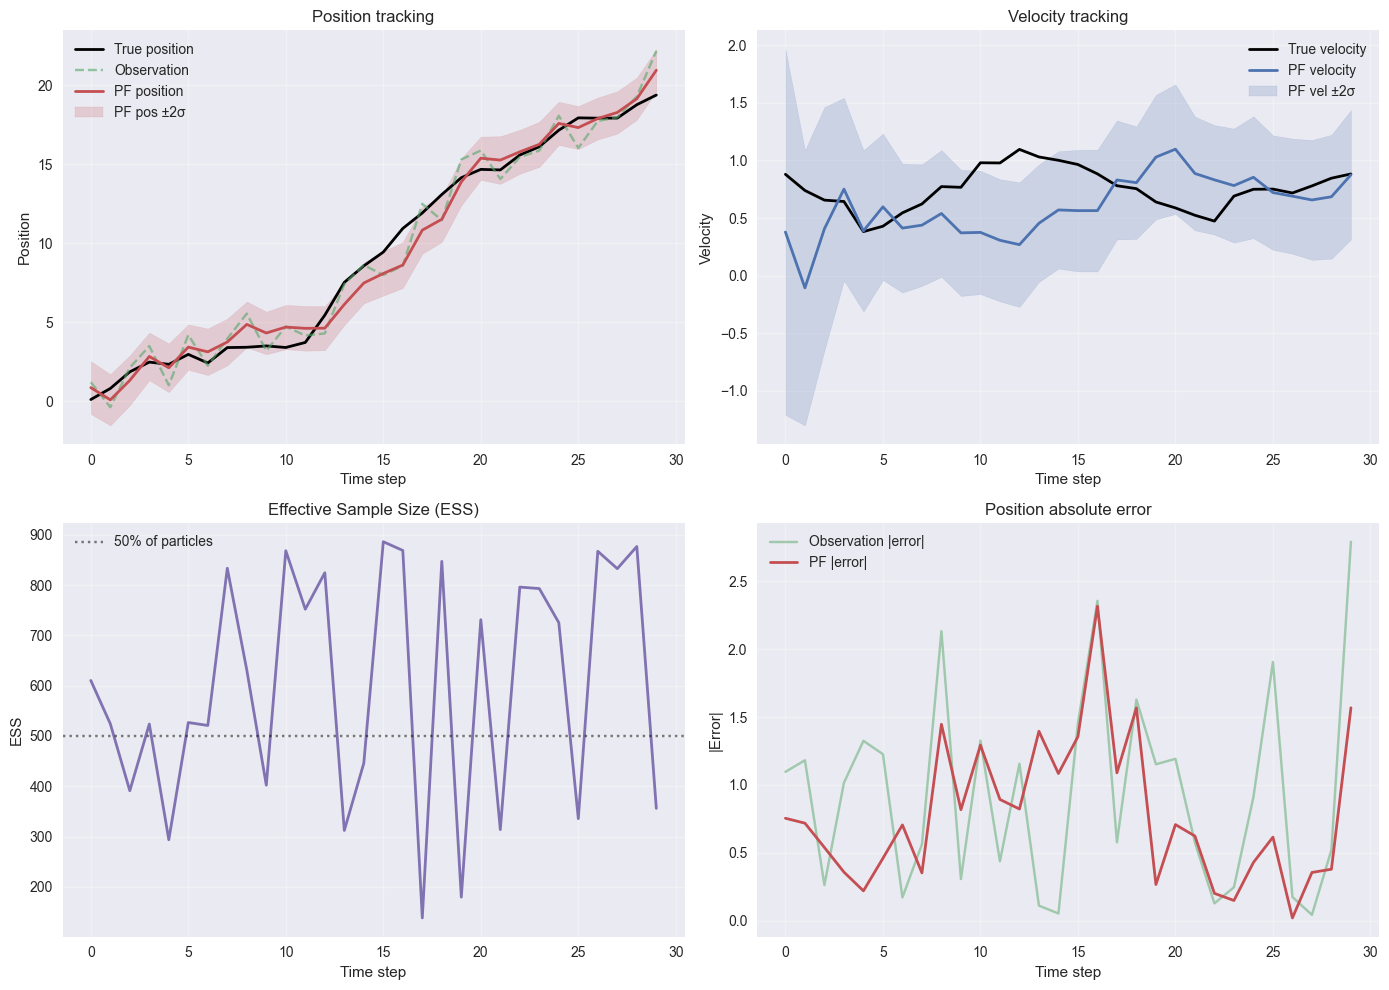

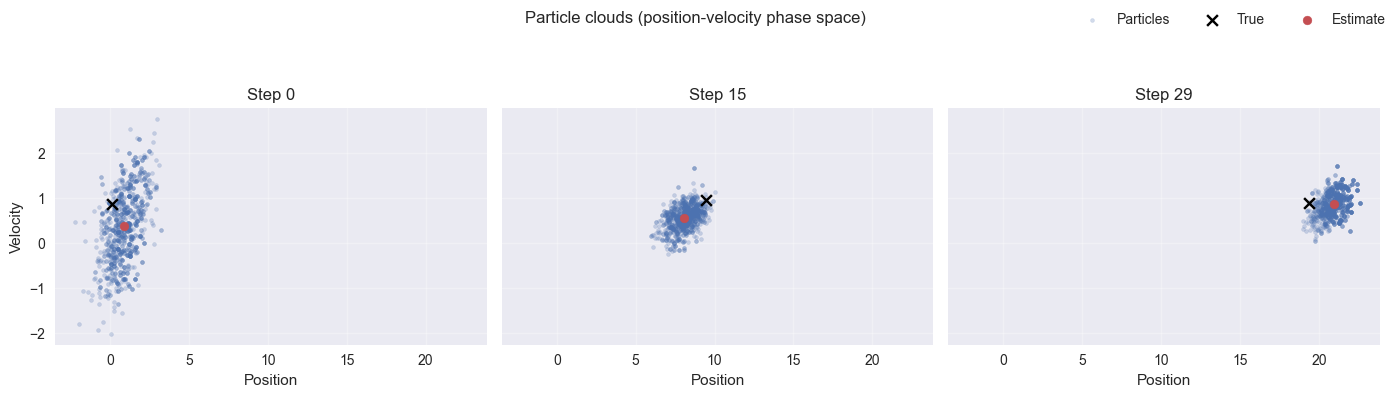

In [ ]:
# Example 2: 2D particle filter - constant-velocity tracking
np.random.seed(123)

# STEP 1: dimensions and noise definitions
state_dim = 2
num_particles = 1000
T = 30

# Motion model: [p, v] -> [p + v, v] with process noise

def motion_model_2d(x):
    pos, vel = x
    new_pos = pos + vel
    new_vel = vel
    return np.array([new_pos, new_vel])

# Observation model: observe position only

def obs_model_2d(x):
    return np.array([x[0]])

process_noise = np.diag([0.5**2, 0.1**2])  # process covariance for position and velocity
observation_noise = np.array([[1.0**2]])  # observation covariance for position

print("=" * 70)
print("2D Particle Filter configuration")
print(f"Particles: {num_particles}, Steps: {T}")
print(f"Process noise std (pos, vel): {(np.sqrt(process_noise.diagonal()))}")
print(f"Observation noise std (pos): {np.sqrt(observation_noise[0, 0]):.3f}")
print("=" * 70)

# STEP 2: define particle filter
pf2d = ParticleFilter(
    num_particles,
    state_dim,
    motion_model_2d,
    obs_model_2d,
    process_noise,
    observation_noise,
)

# STEP 2-0: generate true trajectory and observations
x_true = np.array([0.0, 1.0])  # initial position 0, velocity 1
true_states = []
observations = []
estimates = []
ess_history = []
particle_std_pos = []
particle_std_vel = []
snapshots = {}
snapshot_steps = [0, T // 2, T - 1]

for t in range(T):
    # STEP 2-1: propagate true system and generate observation
    x_true = motion_model_2d(x_true) + np.random.multivariate_normal(np.zeros(state_dim), process_noise)
    z = x_true[0] + np.random.normal(0, np.sqrt(observation_noise[0, 0]))

    true_states.append(x_true.copy())
    observations.append(z)

    # STEP 2-2: predict and update with observation
    pf2d.predict()
    pf2d.update(np.array([z]))

    # STEP 2-3: evaluate ESS and resample
    ess_val = pf2d.effective_sample_size()
    ess_history.append(ess_val)
    pf2d.resample()

    # STEP 2-4: estimate state and variability
    est = pf2d.estimate()
    estimates.append(est)
    particle_std_pos.append(np.std(pf2d.particles[:, 0]))
    particle_std_vel.append(np.std(pf2d.particles[:, 1]))
    if t in snapshot_steps:
        snapshots[t] = pf2d.particles.copy()

true_states = np.array(true_states)
observations = np.array(observations)
estimates = np.array(estimates)
ess_history = np.array(ess_history)
particle_std_pos = np.array(particle_std_pos)
particle_std_vel = np.array(particle_std_vel)
time_axis = np.arange(T)

# STEP 3: metrics
pos_rmse = np.sqrt(np.mean((true_states[:, 0] - estimates[:, 0])**2))
vel_rmse = np.sqrt(np.mean((true_states[:, 1] - estimates[:, 1])**2))
pos_mae = np.mean(np.abs(true_states[:, 0] - estimates[:, 0]))
vel_mae = np.mean(np.abs(true_states[:, 1] - estimates[:, 1]))
obs_pos_rmse = np.sqrt(np.mean((true_states[:, 0] - observations)**2))

print("First few steps (pos_true | obs | pos_est | vel_true | vel_est | ESS | σ_pos | σ_vel):")
for i in range(min(5, T)):
    print(
        f"{i:02d} | {true_states[i, 0]:7.3f} | {observations[i]:7.3f} | "
        f"{estimates[i, 0]:7.3f} | {true_states[i, 1]:7.3f} | {estimates[i, 1]:7.3f} | "
        f"{ess_history[i]:7.1f} | {particle_std_pos[i]:6.3f} | {particle_std_vel[i]:6.3f}"
    )
print("-" * 70)
print(f"Observation-only position RMSE: {obs_pos_rmse:.4f}")
print(f"PF Position -> RMSE: {pos_rmse:.4f}, MAE: {pos_mae:.4f}")
print(f"PF Velocity -> RMSE: {vel_rmse:.4f}, MAE: {vel_mae:.4f}")
print(f"Final ESS: {ess_history[-1]:.1f} / {num_particles}")
print(f"Mean ESS: {np.mean(ess_history):.1f}, Min ESS: {np.min(ess_history):.1f}")
print(f"Final estimate (pos, vel): ({estimates[-1, 0]:.3f}, {estimates[-1, 1]:.3f})")
print(f"True final (pos, vel): ({true_states[-1, 0]:.3f}, {true_states[-1, 1]:.3f})")

# STEP 4: visualization with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# subplot 1: Position with particle spread
axes[0, 0].plot(time_axis, true_states[:, 0], label="True position", linewidth=2, color="k")
axes[0, 0].plot(time_axis, observations, label="Observation", linestyle="--", color="C1", alpha=0.6)
axes[0, 0].plot(time_axis, estimates[:, 0], label="PF position", linewidth=2, color="C2")
axes[0, 0].fill_between(
    time_axis,
    estimates[:, 0] - 2 * particle_std_pos,
    estimates[:, 0] + 2 * particle_std_pos,
    color="C2",
    alpha=0.2,
    label="PF pos ±2σ",
)
axes[0, 0].set_title("Position tracking")
axes[0, 0].set_xlabel("Time step")
axes[0, 0].set_ylabel("Position")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# subplot 2: Velocity with particle spread
axes[0, 1].plot(time_axis, true_states[:, 1], label="True velocity", linewidth=2, color="k")

axes[0, 1].plot(time_axis, estimates[:, 1], label="PF velocity", linewidth=2, color="C0")
axes[0, 1].fill_between(
    time_axis,
    estimates[:, 1] - 2 * particle_std_vel,
    estimates[:, 1] + 2 * particle_std_vel,
    color="C0",
    alpha=0.2,
    label="PF vel ±2σ",
)
axes[0, 1].set_title("Velocity tracking")
axes[0, 1].set_xlabel("Time step")
axes[0, 1].set_ylabel("Velocity")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# subplot 3: ESS
axes[1, 0].plot(time_axis, ess_history, color="C3", linewidth=2)
axes[1, 0].axhline(num_particles * 0.5, color="k", linestyle=":", alpha=0.5, label="50% of particles")
axes[1, 0].set_title("Effective Sample Size (ESS)")
axes[1, 0].set_xlabel("Time step")
axes[1, 0].set_ylabel("ESS")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# subplot 4: Position absolute error
axes[1, 1].plot(time_axis, np.abs(true_states[:, 0] - observations), label="Observation |error|", alpha=0.5, color="C1")
axes[1, 1].plot(time_axis, np.abs(true_states[:, 0] - estimates[:, 0]), label="PF |error|", linewidth=2, color="C2")
axes[1, 1].set_title("Position absolute error")
axes[1, 1].set_xlabel("Time step")
axes[1, 1].set_ylabel("|Error|")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Particle cloud snapshots (phase space)
fig, axes = plt.subplots(1, len(snapshot_steps), figsize=(14, 4), sharex=True, sharey=True)
for ax, step in zip(axes, snapshot_steps):
    cloud = snapshots.get(step)
    if cloud is not None:
        ax.scatter(cloud[:, 0], cloud[:, 1], s=8, alpha=0.25, label="Particles")
        ax.scatter(true_states[step, 0], true_states[step, 1], color="k", marker="x", s=60, label="True")
        ax.scatter(estimates[step, 0], estimates[step, 1], color="C2", marker="o", s=40, label="Estimate")
    ax.set_title(f"Step {step}")
    ax.set_xlabel("Position")
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel("Velocity")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", ncol=3)
fig.suptitle("Particle clouds (position-velocity phase space)")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()